In [1]:
import melign

In [3]:
dataset = melign.Dataset("dataset_test")
assert dataset.is_full()
print(f"Length of dataset: {len(dataset)}")

Length of dataset: 186


In [4]:
new_df, new_alignments = melign.eval_pipeline(
    melign.get_melodics_config(hop_length=1),
    dataset,
    verbose=1,
    baseline=False,
    n_jobs=12)

Processing songs (n_jobs=12):   0%|          | 0/186 [00:00<?, ?it/s]

In [ ]:
a = new_alignments["Letting Go(蔡健雅)"]

Melody([MelEvent_(time=15.91015625, note='D5'), ...(401 events)..., MelEvent_(time=223.47395833333334, note='E5')])

In [6]:
new_df.to_excel("new_result.xlsx")

0.9489919972851321 0.960033984706882


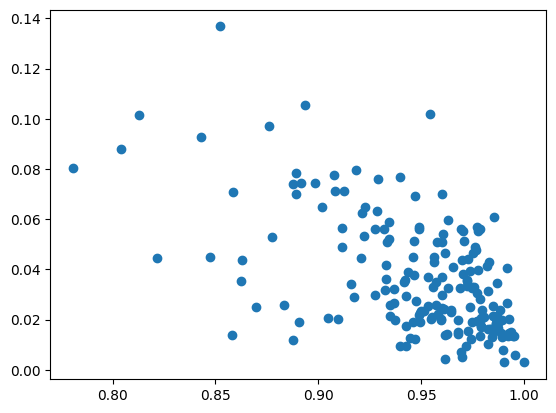

In [12]:
import numpy as np
print(np.mean(new_df["Alignment_F1"][:-1]), np.median(new_df["Alignment_F1"][:-1]))

s = [a.sum_shadow / len(a.events) if len(a.events) > 0 else 0 for a in new_alignments.values()]
b = [a.sum_between / len(a.events) if len(a.events) > 0 else 0 for a in new_alignments.values()]
ab = [a.sum_above_between / len(a.events) if len(a.events) > 0 else 0 for a in new_alignments.values()]
m = [a.sum_miss / len(a.events) if len(a.events) > 0 else 0 for a in new_alignments.values()]
e = [a.sum_error / len(a.events)  if len(a.events) > 0 else 0 for a in new_alignments.values()]

from matplotlib import pyplot as plt

plt.scatter(new_df["Alignment_F1"][:-1], b)

In [18]:
import pandas as pd

f1_prediction = pd.DataFrame(
    {
        "f1": new_df["Alignment_F1"][:-1],
        "precision": new_df["Alignment_Precision"][:-1],
        "recall": new_df["Alignment_Recall"][:-1],
        "between": b,
        "above_between": ab,
        "miss": m,
        "error": e,
        "shadow": s,
    }
)

In [19]:
f1_prediction.to_csv("f1_prediction.csv", index=False)

d:\code\exmel\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\code\exmel\.venv\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


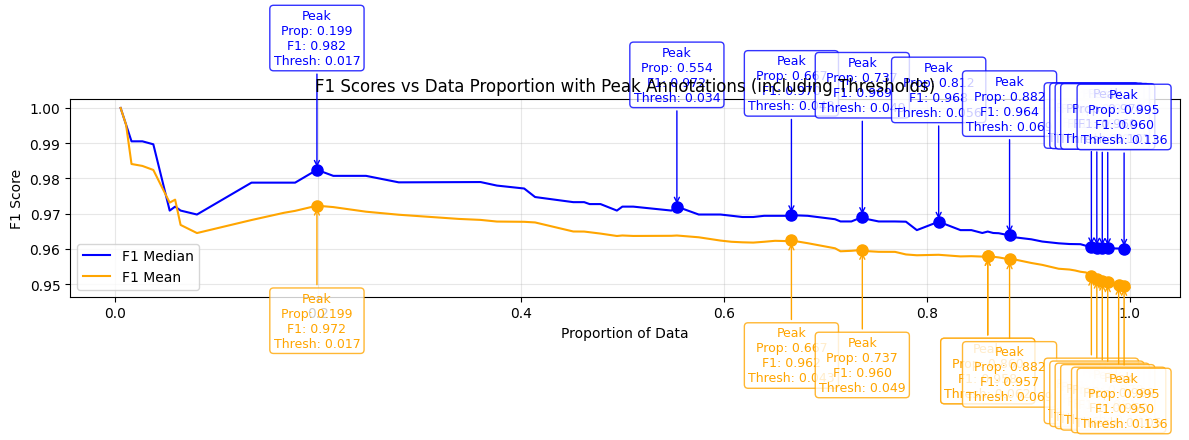


Median peaks:
  Proportion: 0.199, F1: 0.982, Threshold: 0.017
  Proportion: 0.554, F1: 0.972, Threshold: 0.034
  Proportion: 0.667, F1: 0.970, Threshold: 0.043
  Proportion: 0.737, F1: 0.969, Threshold: 0.049
  Proportion: 0.812, F1: 0.968, Threshold: 0.056
  Proportion: 0.882, F1: 0.964, Threshold: 0.069
  Proportion: 0.962, F1: 0.960, Threshold: 0.087
  Proportion: 0.968, F1: 0.960, Threshold: 0.092
  Proportion: 0.973, F1: 0.960, Threshold: 0.097
  Proportion: 0.978, F1: 0.960, Threshold: 0.101
  Proportion: 0.995, F1: 0.960, Threshold: 0.136

Mean peaks:
  Proportion: 0.199, F1: 0.972, Threshold: 0.017
  Proportion: 0.667, F1: 0.962, Threshold: 0.043
  Proportion: 0.737, F1: 0.960, Threshold: 0.049
  Proportion: 0.860, F1: 0.958, Threshold: 0.061
  Proportion: 0.860, F1: 0.958, Threshold: 0.062
  Proportion: 0.882, F1: 0.957, Threshold: 0.069
  Proportion: 0.962, F1: 0.952, Threshold: 0.087
  Proportion: 0.968, F1: 0.952, Threshold: 0.092
  Proportion: 0.973, F1: 0.951, Threshold

In [8]:
import numpy as np
import matplotlib.pyplot as plt

f1_means = []
f1_medians = []
counts = []

thresholds = np.arange(0.001, 0.2, 0.001)

for threshold in thresholds:
    f1_scores = []
    
    for f1, between in zip(new_df["Alignment_F1"][:-1], b):
        if between < threshold and f1 > 0.5:
            f1_scores.append(f1)
    
    f1_means.append(np.mean(f1_scores))
    f1_medians.append(np.median(f1_scores))
    counts.append(len(f1_scores))

# Convert to arrays for easier manipulation
proportions = np.array(counts) / len(new_df["Alignment_F1"][:-1])
f1_means = np.array(f1_means)
f1_medians = np.array(f1_medians)

# Plot the curves
plt.figure(figsize=(12, 8))
plt.plot(proportions, f1_medians, label='F1 Median', color='blue')
plt.plot(proportions, f1_means, label='F1 Mean', color='orange')

# Function to find peaks using sliding window
def find_peaks_sliding_window(y_values, window_size=5):
    peaks = []
    half_window = window_size // 2
    
    for i in range(half_window, len(y_values) - half_window):
        window = y_values[i - half_window:i + half_window + 1]
        if y_values[i] == np.max(window):
            # Check if it's a true peak (not a plateau)
            if i > 0 and i < len(y_values) - 1:
                if y_values[i] > y_values[i-1] or y_values[i] > y_values[i+1]:
                    peaks.append(i)
    
    return peaks

# Find peaks for both curves
median_peaks = find_peaks_sliding_window(f1_medians, window_size=7)
mean_peaks = find_peaks_sliding_window(f1_means, window_size=7)

# Annotate peaks for medians
for peak_idx in median_peaks:
    annotation_text = (f'Peak\n'
                      f'Prop: {proportions[peak_idx]:.3f}\n'
                      f'F1: {f1_medians[peak_idx]:.3f}\n'
                      f'Thresh: {thresholds[peak_idx]:.3f}')
    
    plt.annotate(annotation_text,
                xy=(proportions[peak_idx], f1_medians[peak_idx]),
                xytext=(proportions[peak_idx], f1_medians[peak_idx] + 0.03),
                ha='center',
                fontsize=9,
                color='blue',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='blue', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='blue', lw=1))
    plt.plot(proportions[peak_idx], f1_medians[peak_idx], 'bo', markersize=8)

# Annotate peaks for means
for peak_idx in mean_peaks:
    annotation_text = (f'Peak\n'
                      f'Prop: {proportions[peak_idx]:.3f}\n'
                      f'F1: {f1_means[peak_idx]:.3f}\n'
                      f'Thresh: {thresholds[peak_idx]:.3f}')
    
    plt.annotate(annotation_text,
                xy=(proportions[peak_idx], f1_means[peak_idx]),
                xytext=(proportions[peak_idx], f1_means[peak_idx] - 0.04),
                ha='center',
                fontsize=9,
                color='orange',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='orange', alpha=0.8),
                arrowprops=dict(arrowstyle='->', color='orange', lw=1))
    plt.plot(proportions[peak_idx], f1_means[peak_idx], 'o', color='orange', markersize=8)

plt.xlabel('Proportion of Data')
plt.ylabel('F1 Score')
plt.title('F1 Scores vs Data Proportion with Peak Annotations (including Thresholds)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed peak information
print("\nMedian peaks:")
for i in median_peaks:
    print(f"  Proportion: {proportions[i]:.3f}, F1: {f1_medians[i]:.3f}, Threshold: {thresholds[i]:.3f}")

print("\nMean peaks:")
for i in mean_peaks:
    print(f"  Proportion: {proportions[i]:.3f}, F1: {f1_means[i]:.3f}, Threshold: {thresholds[i]:.3f}")

In [39]:
from collections import defaultdict

song_to_metrics: dict[str, dict[str, float]] = defaultdict(lambda: dict(tp=0, fp=0))

for name, alignment in new_alignments.items():
    for match in alignment.matches:
        for event_left, event_right in zip(match.events[:-1], match.events[1:]):
            potential_between = dataset[name].performance.global_between(event_left.time+0.1, event_right.time-0.1)
            for b in potential_between:
                # if (event_left.note <= b.note <= event_right.note) or \
                #     (event_right.note <= b.note <= event_left.note):
                if b.note > event_left.note and b.note > event_right.note:
                    if melign.align.score.is_tp(b, dataset[name].melody):
                        song_to_metrics[name]["tp"] += 1
                    else:
                        song_to_metrics[name]["fp"] += 1

for name, metrics in song_to_metrics.items():
    print(name, metrics)

Letting Go(蔡健雅) {'tp': 0, 'fp': 6}
On My Way(萨吉) {'tp': 0, 'fp': 5}
Speechless(Naomi Scott) {'tp': 0, 'fp': 1}
The Best For You(欧阳娜娜) {'tp': 0, 'fp': 9}
Too Bad(林俊杰) {'tp': 0, 'fp': 1}
Young and Beautiful(Lana Del Rey) {'tp': 0, 'fp': 39}
一切都来得及(贾玲) {'tp': 0, 'fp': 15}
一生一次心一动(张靓颖) {'tp': 0, 'fp': 1}
一生不变(李克勤) {'tp': 0, 'fp': 29}
一生与你擦肩而过(阿悠悠) {'tp': 2, 'fp': 28}
一荤一素(毛不易) {'tp': 0, 'fp': 2}
一辈子守候(HANA菊梓乔) {'tp': 1, 'fp': 10}
不为谁而作的歌(林俊杰) {'tp': 0, 'fp': 44}
不是我不小心(张镐哲) {'tp': 0, 'fp': 11}
不爱我(薛之谦) {'tp': 2, 'fp': 60}
不知所措(王靖雯) {'tp': 0, 'fp': 34}
不能说的秘密(周杰伦) {'tp': 0, 'fp': 1}
不遗憾(李荣浩) {'tp': 0, 'fp': 17}
与我无关(阿冗) {'tp': 1, 'fp': 16}
丢了你(井胧) {'tp': 0, 'fp': 9}
中国姑娘(金志文) {'tp': 0, 'fp': 5}
乌梅子酱(李荣浩) {'tp': 0, 'fp': 19}
云之羽(张杰) {'tp': 0, 'fp': 12}
人世间(雷佳) {'tp': 0, 'fp': 4}
人是_(周深) {'tp': 0, 'fp': 6}
从前说(小阿七) {'tp': 0, 'fp': 4}
以父之名(周杰伦) {'tp': 0, 'fp': 2}
会呼吸的痛(梁静茹) {'tp': 1, 'fp': 6}
你不知道的事(王力宏) {'tp': 0, 'fp': 4}
你啊你啊(魏如萱) {'tp': 0, 'fp': 1}
你就不要想起我(田馥甄) {'tp': 1, 'fp': 11}
你的答案(阿冗) 

In [8]:
for name, metrics in song_to_metrics.items():
    print(name, metrics)

All of Me(John Legend) {'tp': 3, 'fp': 35}
K歌之王(陈奕迅) {'tp': 2, 'fp': 19}
My Heart Will Go On(Celine Dion) {'tp': 2, 'fp': 148}
一人之境(林家谦) {'tp': 1, 'fp': 42}
不为谁而作的歌(林俊杰) {'tp': 1, 'fp': 20}
不能说的秘密(周杰伦) {'tp': 0, 'fp': 43}
与我无关(阿冗) {'tp': 9, 'fp': 68}
争气(容祖儿) {'tp': 1, 'fp': 30}
从前说(小阿七) {'tp': 2, 'fp': 24}
以父之名(周杰伦) {'tp': 3, 'fp': 84}
你啊你啊(魏如萱) {'tp': 5, 'fp': 54}
你给我听好(陈奕迅) {'tp': 1, 'fp': 81}
倒影(周杰伦) {'tp': 2, 'fp': 53}
光年之外(邓紫棋) {'tp': 0, 'fp': 6}
凉凉(杨宗纬、张碧晨) {'tp': 6, 'fp': 114}
唯一(邓紫棋) {'tp': 0, 'fp': 21}
如一(任嘉伦) {'tp': 6, 'fp': 48}
孤单心事(蓝又时) {'tp': 7, 'fp': 85}
安静(周杰伦) {'tp': 2, 'fp': 19}
想见你想见你想见你(八三夭乐团) {'tp': 14, 'fp': 75}
慢冷(梁静茹) {'tp': 2, 'fp': 33}
慢慢喜欢你(莫文蔚) {'tp': 1, 'fp': 44}
我曾遇到一束光(叶斯淳) {'tp': 4, 'fp': 44}
明天会更好(华语群星) {'tp': 7, 'fp': 135}
是妈妈是女儿(黄绮珊、希林娜依高) {'tp': 2, 'fp': 41}
暗号(周杰伦) {'tp': 7, 'fp': 141}
月牙湾(F.I.R.) {'tp': 3, 'fp': 43}
来迟(戴羽彤) {'tp': 3, 'fp': 68}
梦一场(那英) {'tp': 2, 'fp': 80}
王招君(任素汐) {'tp': 2, 'fp': 45}
用力活着(张茜) {'tp': 10, 'fp': 148}
给电影人的情书(单依纯) {'tp':

In [6]:
for name, metrics in song_to_metrics.items():
    print(name, metrics)

All of Me(John Legend) {'tp': 3, 'fp': 35}
K歌之王(陈奕迅) {'tp': 2, 'fp': 19}
My Heart Will Go On(Celine Dion) {'tp': 2, 'fp': 148}
一人之境(林家谦) {'tp': 1, 'fp': 42}
不为谁而作的歌(林俊杰) {'tp': 1, 'fp': 20}
不能说的秘密(周杰伦) {'tp': 0, 'fp': 43}
与我无关(阿冗) {'tp': 9, 'fp': 68}
争气(容祖儿) {'tp': 1, 'fp': 30}
从前说(小阿七) {'tp': 2, 'fp': 24}
以父之名(周杰伦) {'tp': 3, 'fp': 84}
你啊你啊(魏如萱) {'tp': 5, 'fp': 54}
你给我听好(陈奕迅) {'tp': 1, 'fp': 81}
倒影(周杰伦) {'tp': 2, 'fp': 53}
光年之外(邓紫棋) {'tp': 0, 'fp': 6}
凉凉(杨宗纬、张碧晨) {'tp': 6, 'fp': 114}
唯一(邓紫棋) {'tp': 0, 'fp': 21}
如一(任嘉伦) {'tp': 6, 'fp': 48}
孤单心事(蓝又时) {'tp': 7, 'fp': 85}
安静(周杰伦) {'tp': 2, 'fp': 19}
想见你想见你想见你(八三夭乐团) {'tp': 14, 'fp': 75}
慢冷(梁静茹) {'tp': 2, 'fp': 33}
慢慢喜欢你(莫文蔚) {'tp': 1, 'fp': 44}
我曾遇到一束光(叶斯淳) {'tp': 4, 'fp': 44}
明天会更好(华语群星) {'tp': 7, 'fp': 135}
是妈妈是女儿(黄绮珊、希林娜依高) {'tp': 2, 'fp': 41}
暗号(周杰伦) {'tp': 7, 'fp': 141}
月牙湾(F.I.R.) {'tp': 3, 'fp': 43}
来迟(戴羽彤) {'tp': 3, 'fp': 68}
梦一场(那英) {'tp': 2, 'fp': 80}
王招君(任素汐) {'tp': 2, 'fp': 45}
用力活着(张茜) {'tp': 10, 'fp': 148}
给电影人的情书(单依纯) {'tp':

In [9]:
result_df

,Sample,Alignment_Precision,Alignment_Recall,Alignment_F1,Runtime_seconds
0,All of Me(John Legend),0.988426,0.908511,0.946785,6.028765
1,K歌之王(陈奕迅),0.997253,0.945312,0.970588,2.395073
2,My Heart Will Go On(Celine Dion),0.913242,0.738007,0.816327,4.408114
3,一人之境(林家谦),0.947712,0.966667,0.957096,1.568727
4,不为谁而作的歌(林俊杰),0.965789,0.953247,0.959477,6.149545
5,不能说的秘密(周杰伦),0.991667,0.962264,0.976744,3.398893
6,与我无关(阿冗),0.973856,0.814208,0.886905,4.552399
7,争气(容祖儿),0.997368,0.904535,0.948686,4.009174
8,从前说(小阿七),1.000000,0.976699,0.988212,3.925611
9,以父之名(周杰伦),0.964339,0.830986,0.892710,16.079974
